# CESM1-DPLE: ENSO Check 
 - Examine Nino3.4 prediction at early lead times
 - Demonstrates efficient use of dask for processing DPLE data on campaign  

In [1]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import matplotlib.pyplot as plt
import cesm_esptools
%matplotlib inline

## Create Dask Cluster

In [17]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [2]:
# ONLY RUN THIS CELL ONCE
# NOTE: you may need to change the project number
from dask_jobqueue import PBSCluster
from dask.distributed import Client
proj = 'NCGD0011'

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project=proj, # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
#cluster.scale(18)
cluster.adapt(minimum=1,maximum=20,wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
#cluster
client
#client.restart() #for when workers get dropped or other oops moments

Client Scheduler: tcp://10.12.206.54:40638 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/emaroon/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Data I/O functions:
 - Now inside package


# Main Processing

### Read in POP monthly field
- Design preprocessing function tailored for task 
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead month)
- "time" and "time_bound" variables, which give prediction verification time, are also dimensioned with (Y,L) 

In [4]:
#Setting up functions

field = 'TEMP'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/ocn/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetemplate = datadir+field+'/'+casename+'.pop.h.'+field+'.*.nc'
ens = range(40) 
#leadtimes = range(122)
ltimes = 24
leadtimes = range(ltimes)
firstyear = 1970
lastyear  = 2018
startmonth = 11

## User tasks go here; currently a required input for get_monthly_data;
def preprocess(ds):
    return ds.isel({'z_t':0, 'time':slice(0,ltimes)})

In [5]:
%%time
# DPLE data
# process all 40 ensemble members, first 24 months, all November start dates from 1970-2018:

#chunks={'z_t':1,'nlat':80}
dple_temp = cesm_esptools.get_monthly_data(filetemplate, ens, leadtimes, field, firstyear, lastyear, startmonth,\
                                         preprocess, client=client)
dple_temp.nbytes/1e9 #GB

<xarray.Dataset>
Dimensions:               (L: 24, M: 40, Y: 48, d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, transport_comp: 5, transport_reg: 2, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates: (12/14)
    z_t                   float32 500.0
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                    ...
    ULAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * 

22.656151432

In [6]:
# Load this in memory to speed up later computations
dple_temp = dple_temp.persist()

### Compute Nino3.4 Index

In [7]:
def POP_regional_areawgt(ds,lon_lim,lat_lim):
    tarea = ds.TAREA
    tlat = ds.TLAT
    tlon = xr.where(ds.TLONG>180.,ds.TLONG-360.,ds.TLONG)
    region = (tlat>=lat_lim[0]) & (tlat<=lat_lim[1]) & (tlon>=lon_lim[0]) & (tlon<=lon_lim[1])
    return xr.where(region,tarea.fillna(0),0)

In [8]:
POPg16_nino34_area = POP_regional_areawgt(dple_temp,[-170.,-120.],[-5.,5])

- Here, perform actual computation, returning xarray

In [9]:
%%time
dple_nino34 = dple_temp.TEMP.weighted(POPg16_nino34_area).mean(("nlon", "nlat")).load()
dple_time_bound = dple_temp.time_bound.load()


CPU times: user 39.7 s, sys: 846 ms, total: 40.6 s
Wall time: 2min 42s


In [ ]:
#dple_nino34.load()
#time_bound.load()

In [ ]:
# Look at the result
#dple_nino34

In [10]:
# Observed Nino3.4 (NOAA ERSSTv5)
ds_obs = xr.open_dataset('/glade/p/cgd/oce/people/yeager/obs/SST/NOAA_ERSSTv5/ersst.v5.188001-202012.gx1v6.nc',decode_times=False)
obs_time_vals = [cftime.DatetimeNoLeap(1880+year, 1+month, 15) for year in range(141) for month in range(12)]
ds_obs['time'] = obs_time_vals
obs_nino34 = ds_obs.sst.weighted(POPg16_nino34_area).mean(("nlon", "nlat")).load()


### Drift Removal
- Drift removal by lead time 

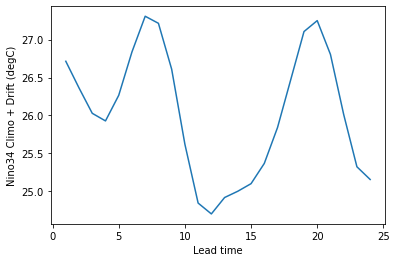

In [11]:
#Set the start and end year (inclusive) for the climotology
cl_y1 = 1980
cl_y2 = 1999 

cl_d1 = cftime.DatetimeNoLeap(cl_y1,1,1,0,0,0)
cl_d2 = cftime.DatetimeNoLeap(cl_y2,12,31,23,59,59)

fordrift = dple_nino34.where((dple_time_bound.mean('d2')>cl_d1) & (dple_time_bound.mean('d2')<cl_d2))
climodrift = fordrift.mean('M').mean('Y')

dple_nino34_anom = dple_nino34 - climodrift


obs_nino34_anom = obs_nino34.groupby('time.month') - obs_nino34.sel(time=slice(cl_d1,cl_d2)).groupby('time.month').mean('time')

plt.plot(climodrift.L, climodrift)
plt.xlabel('Lead time')
plt.ylabel('Nino34 Climo + Drift (degC)');


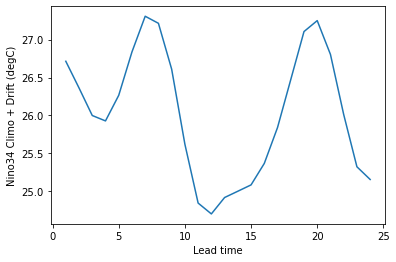

In [17]:
#Using package instead
dple_nino34_anom, nino34_climodrift = cesm_esptools.remove_drift(dple_nino34, dple_time_bound, cl_y1, cl_y2)

plt.plot(nino34_climodrift.L, nino34_climodrift)
plt.xlabel('Lead time')
plt.ylabel('Nino34 Climo + Drift (degC)');


### Generate Plot
- For some reason, I can't get `errorbar` or `scatter` plot methods to handle the cftime.DatetimeNoLeap time values. `plot` can handle it. 
The error message reports it needs cftime.datetime objects, but isinstance(dpletime.values[0],cftime.datetime) returns True.

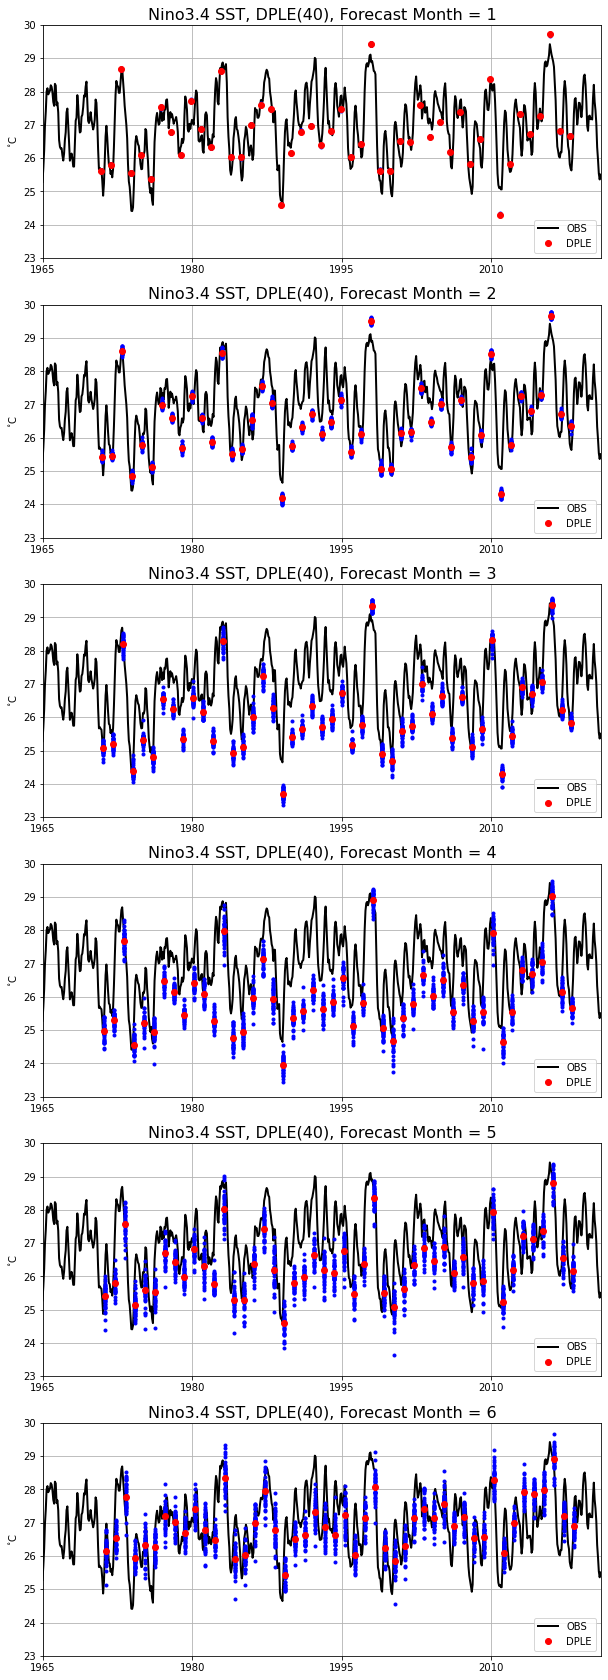

In [14]:
nlead = 6
fig = plt.figure(figsize=(10, nlead*5))
nrow = nlead
ncol = 1

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = cftime.num2date(0, 'days since 1965-01-01 00:00:00', calendar='noleap')
xmax = cftime.num2date(0, 'days since 2021-01-01 00:00:00', calendar='noleap')

for i in range(nlead):
    thislead = i+1    
    dpletime = dple_time_bound.sel(L=thislead).mean('d2')
    ax = fig.add_subplot(nrow,ncol,i*ncol+1)
    ax.plot(obs_nino34.time, obs_nino34,linewidth=2,color='k',label='OBS')
    ax.plot(dpletime,dple_nino34.sel(L=thislead),'.',color='b')
    ax.plot(dpletime,dple_nino34.sel(L=thislead).mean('M'),'o',color='r',label='DPLE')
    ax.grid()
    ax.set_title('Nino3.4 SST, DPLE(40), Forecast Month = {}'.format(thislead), fontdict={'size':16})
    ax.set_ylabel(r'$^{\circ}$C')
    ax.set_ylim(23,30)
    ax.set_xlim(xmin,xmax)
#    ax.set_xticks(xtickyears)
    ax.legend(loc='lower right')


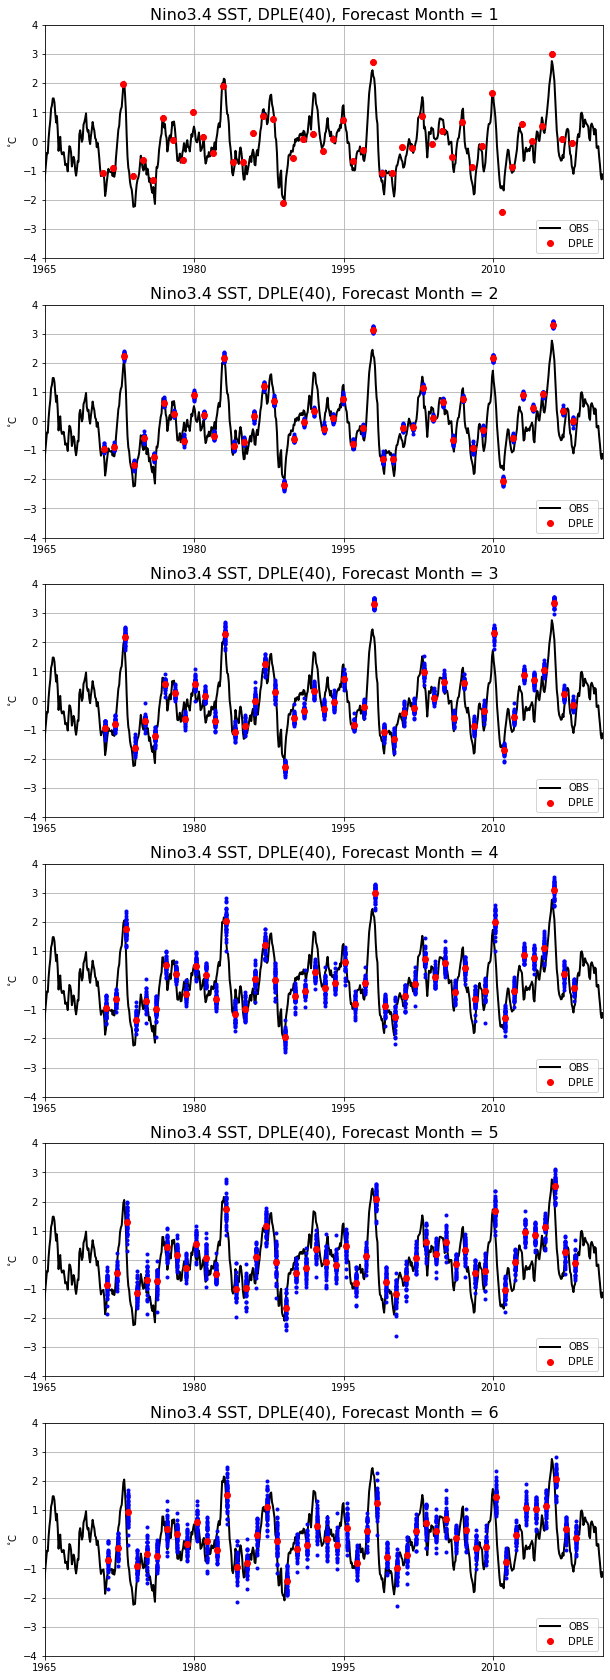

In [15]:
nlead = 6
fig = plt.figure(figsize=(10, nlead*5))
nrow = nlead
ncol = 1

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = cftime.num2date(0, 'days since 1965-01-01 00:00:00', calendar='noleap')
xmax = cftime.num2date(0, 'days since 2021-01-01 00:00:00', calendar='noleap')

for i in range(nlead):
    thislead = i+1    
    dpletime = dple_time_bound.sel(L=thislead).mean('d2')
    ax = fig.add_subplot(nrow,ncol,i*ncol+1)
    ax.plot(obs_nino34.time, obs_nino34_anom,linewidth=2,color='k',label='OBS')
    ax.plot(dpletime,dple_nino34_anom.sel(L=thislead),'.',color='b')
    ax.plot(dpletime,dple_nino34_anom.sel(L=thislead).mean('M'),'o',color='r',label='DPLE')
    ax.grid()
    ax.set_title('Nino3.4 SST, DPLE(40), Forecast Month = {}'.format(thislead), fontdict={'size':16})
    ax.set_ylabel(r'$^{\circ}$C')
    ax.set_ylim(-4,4)
    ax.set_xlim(xmin,xmax)
#    ax.set_xticks(xtickyears)
    ax.legend(loc='lower right')
